# GEDI Waveform Convolutional Autoencoder Demo

## 1. Load Data

In [25]:
# import standard libraries
import os
import numpy as np
from pathlib import Path

# import ML libraries
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# import visualization libraries
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
# get path to cwd and set project root
notebook_dir = Path.cwd()
project_root = notebook_dir.parent

# define full path to dataset and load
data_path =  os.path.join(project_root, 'data/gedi_waveforms_tf.npz')
data = np.load(data_path)

In [27]:
# Extract waveform data
waveforms = data['waveforms']

# Add new axis to waveform data
waveforms = waveforms[..., np.newaxis]

# inspect waveform data and shape
print(waveforms.shape)
print(waveforms)

(10546, 500, 1)
[[[-0.92182818]
  [-1.11135732]
  [-1.0882749 ]
  ...
  [-0.82720233]
  [-0.7545843 ]
  [-0.65852474]]

 [[-0.51685445]
  [-0.91077666]
  [-1.0163088 ]
  ...
  [-1.14346151]
  [-0.74755905]
  [-0.30184295]]

 [[-0.47643436]
  [-0.54564899]
  [-0.33103624]
  ...
  [ 0.23716828]
  [ 0.30925776]
  [ 0.10473613]]

 ...

 [[-1.01867713]
  [-1.48746914]
  [-1.54916126]
  ...
  [-0.18743011]
  [-0.19228905]
  [-0.06010556]]

 [[ 0.06117187]
  [ 0.00706989]
  [-0.20781391]
  ...
  [-0.20177718]
  [-0.17382068]
  [-0.17141481]]

 [[-0.78835739]
  [-0.72094595]
  [-0.28164888]
  ...
  [ 0.97619698]
  [ 0.64958933]
  [ 0.17167537]]]


In [28]:
# inspect metadata
meta = data['metadata']
meta

array([[2.62105003e+16, 3.37470437e+01, 1.07560844e+02, 2.19235275e+03,
        2.08168307e+03],
       [2.62105003e+16, 3.37466958e+01, 1.07561272e+02, 2.23949513e+03,
        2.09243467e+03],
       [2.62105003e+16, 3.37463476e+01, 1.07561700e+02, 2.28555638e+03,
        2.16545186e+03],
       ...,
       [2.20390800e+17, 3.36853646e+01, 1.07647559e+02, 2.37597998e+03,
        2.26107509e+03],
       [2.20390800e+17, 3.36846582e+01, 1.07648432e+02, 2.32647817e+03,
        2.21726621e+03],
       [2.20391100e+17, 3.36953802e+01, 1.07625936e+02, 2.38611265e+03,
        2.28064366e+03]])

## 2. Split Data for Training and Validation

In [32]:
# Split dataset into training and validation sets (80/20 split)
x_train, x_temp = train_test_split(waveforms, test_size = 0.2, random_state = 0)
x_test, x_val = train_test_split(x_temp, test_size = 0.5, random_state = 0)

# inspect the shape of the training and validation sets
print(f"Training data:  {x_train.shape}")
print(f"Testing data:  {x_test.shape}")
print(f"Validation data: {x_val.shape}")


Training data:  (8436, 500, 1)
Testing data:  (1055, 500, 1)
Validation data: (1055, 500, 1)


## 3. Build and Compile Baseline CAE

In [ ]:
def Build_Baseline_CAE(input_shape):
    # Encoder
    inputs = layers.Input(shape=input_shape, name = 'input_layer')
    x = layers.Conv1D(32, kernel_size = 3, activation = 'relu', padding = 'same')(inputs)
    x = layers.MaxPooling1D(2, padding = 'same')(x)
    x = layers.Conv1D(64, kernel_size = 3, activation = 'relu', padding = 'same')(x)
    encoded = layers.MaxPooling1D(2, padding = 'same')(x)

    encoder = models.Model(inputs, encoded, name = 'encoder')

    # Decoder
    decoder_input = layers.Input(shape=encoded.shape[1:], name = "decoder_input")
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(decoder_input)
    x = layers.UpSampling1D(2)(x)
    x = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(2)(x)
    decoded = layers.Conv1D(1, kernel_size=3, activation='linear', padding='same')(x)

    decoder = models.Model(decoder_input, decoded, name="decoder")

    # Autoencoder Model
    autoencoder_output = decoder(encoder(inputs))
    autoencoder = models.Model(inputs, autoencoder_output, name="autoencoder")
    autoencoder.compile(optimizer=optimizers.Adam(1e-3), loss='mse')

    return autoencoder, encoder, decoder

In [ ]:
# Build the model
input_shape = x_train.shape[1:]
autoencoder, encoder, decoder = Build_Baseline_CAE(input_shape)

In [44]:
# Summarize models
autoencoder.summary()
encoder.summary()
decoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 500, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 125, 64)        │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 500, 1)         │        18,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,961 (97.50 KB)

 Trainable params: 24,961 (97.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 500, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 500, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 250, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 250, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 125, 64)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,336 (24.75 KB)

 Trainable params: 6,336 (24.75 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 125, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 125, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 250, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_3 (UpSampling1D)  │ (None, 500, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 500, 1)         │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,625 (72.75 KB)

 Trainable params: 18,625 (72.75 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Train Baseline Autoencoder

In [45]:
import datetime

# Set TensorBoard logging directory
log_dir = project_root / "logs" / datetime.datetime.now().strftime("fit-%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=64,
    validation_data=(x_val, x_val),
    callbacks=[tensorboard_callback]
)

Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.2004 - val_loss: 0.0049
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0044 - val_loss: 0.0023
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0011 - val_loss: 9.3667e-04
Epoch 10/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0010 - val_loss: 9.2042e-04
Epoch 11/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9.8750e-04 - val_loss: 8.0213e-04
Epoch 12/50
132/132 ━━━━━

## 5. Evaluate Baseline AE on Test Set

In [48]:
test_loss = autoencoder.evaluate(x_test, x_test, verbose=1)
print(f"\nFinal reconstruction loss on TEST set: {test_loss:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4700e-04

Final reconstruction loss on TEST set: 0.0003


## 6. Visualize Loss Curve

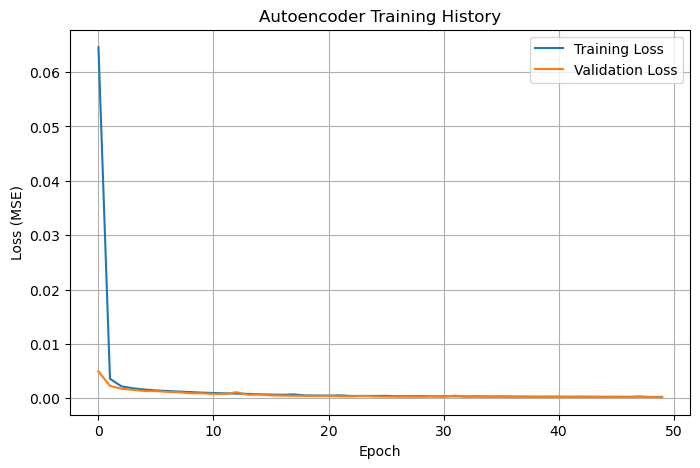

In [46]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 7. Visualize OG vs. Reconstructed Waveforms

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


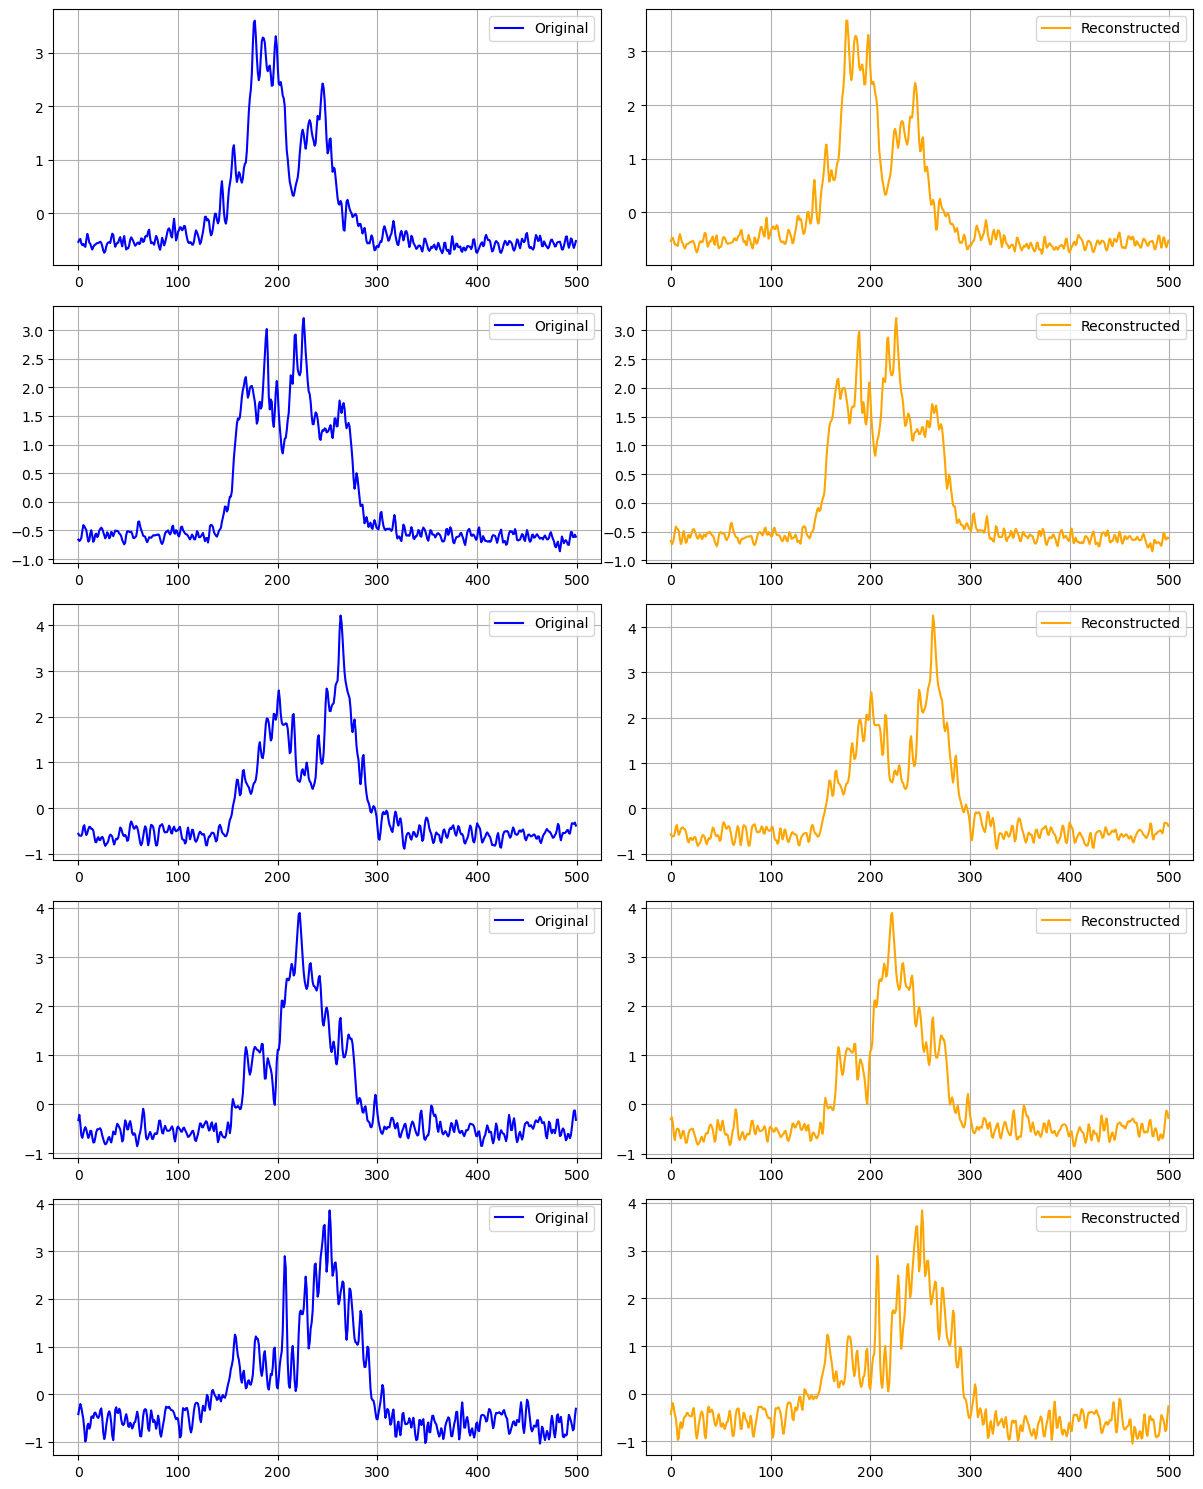

In [47]:
def plot_reconstructions(model, data, n=5):
    reconstructions = model.predict(data[:n])
    plt.figure(figsize=(12, 3 * n))
    for i in range(n):
        plt.subplot(n, 2, 2*i + 1)
        plt.plot(data[i].squeeze(), color='blue', label='Original')
        plt.legend()
        plt.grid(True)

        plt.subplot(n, 2, 2*i + 2)
        plt.plot(reconstructions[i].squeeze(), color='orange', label='Reconstructed')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Visualize reconstructions on test set
plot_reconstructions(autoencoder, x_val, n=5)

## 8. Extract Embeddings 

In [52]:
# Example: encode test set to latent representations
val_embeddings = encoder.predict(x_val)
print("Latent embeddings shape:", val_embeddings.shape)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Latent embeddings shape: (1055, 125, 64)


## 9. Conclusion

This notebook demonstrates a working 1D convolutional autoencoder (CAE) applied to z-score normalized GEDI L1B waveforms. The model performs well in reconstructing the input data and serves as a functional proof-of-concept for learning unsupervised representations from GEDI waveform data.

The latent vectors produced here reflect a transformed encoding of waveform shape, but their utility as **compressed**, **biologically-meaningful** features are minimal. 

We explore how different architectural and training decisions affect the compactness and utility of the embeddings in the `convolutional_autoencoder_experiments.ipynb` notebook, which systematically tests and evaluates different model configurations.